In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.metrics import root_mean_squared_error, mean_absolute_percentage_error, r2_score
from matplotlib import rcParams
from sklearn.preprocessing import MinMaxScaler
import numpy as np

rcParams['figure.figsize'] = 18, 6

In [27]:
df = pd.read_csv("data/bbas3_info.csv")
df.head()

,Date,BBAS3,SELIC,Cambio,IPCA
0,2017-01-02,8.264061,0.1375,3.2723,0.05354
1,2017-01-03,8.642155,0.1375,3.2626,0.05354
2,2017-01-04,8.597146,0.1375,3.2327,0.05354
3,2017-01-05,8.576143,0.1375,3.2123,0.05354
4,2017-01-06,8.669160,0.1375,3.2051,0.05354


In [28]:
df["Date"] = pd.to_datetime(df["Date"])

In [29]:
df.index = df["Date"]

In [30]:
df["BBAS3 Ontem"] = df['BBAS3'].shift(1)

In [31]:
df.head()

,Date,BBAS3,SELIC,Cambio,IPCA,BBAS3 Ontem
Date,,,,,,
2017-01-02,2017-01-02,8.264061,0.1375,3.2723,0.05354,NaN
2017-01-03,2017-01-03,8.642155,0.1375,3.2626,0.05354,8.264061
2017-01-04,2017-01-04,8.597146,0.1375,3.2327,0.05354,8.642155
2017-01-05,2017-01-05,8.576143,0.1375,3.2123,0.05354,8.597146
2017-01-06,2017-01-06,8.669160,0.1375,3.2051,0.05354,8.576143


In [32]:
df.dropna(inplace=True)

In [33]:
df.shape

(1985, 6)

In [73]:
scaler = MinMaxScaler()
y = scaler.fit_transform(df["BBAS3"].values.reshape(-1, 1))
X = scaler.fit_transform(df["BBAS3 Ontem"].values.reshape(-1, 1))

In [74]:
y_train, y_test = y[:1786], y[1786:]
X_train, X_test = X[:1786], X[1786:]

In [77]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# 1. Definir modelo
model = Sequential([
    LSTM(50, activation="tanh", input_shape=(1, 1)),  # 50 neurônios, input = (timesteps=1, features=1)
    # Dense(units=10, activation = 'linear'),
    Dense(1)  # Saída (preço previsto)
])

# 2. Compilar
model.compile(optimizer="adam", loss="mse")  # Otimizador Adam, erro quadrático médio

# 3. Treinar
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test, y_test)
)

Epoch 1/50


c:\Users\felip\Felipe\Projetos\TCC\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1156 - val_loss: 0.3136
Epoch 2/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0309 - val_loss: 0.1167
Epoch 3/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0183 - val_loss: 0.0781
Epoch 4/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0119 - val_loss: 0.0395
Epoch 5/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0065 - val_loss: 0.0147
Epoch 6/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0027 - val_loss: 0.0027
Epoch 7/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.1144e-04 - val_loss: 2.0503e-04
Epoch 8/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.8370e-04 - val_loss: 4.5416e-04
Epoch 9/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.1727e-04 - val_loss: 7.8741e-04
Epoch 10/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.9593e-04 - val_loss: 6.5597e-04
Epoch 11/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.1217e-04 - val_loss: 8.4211e-04
Epoch 12/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
MAPE: 0.008273519324203216
RMSE: 0.27319038434545834
R²: 0.9086550843218768


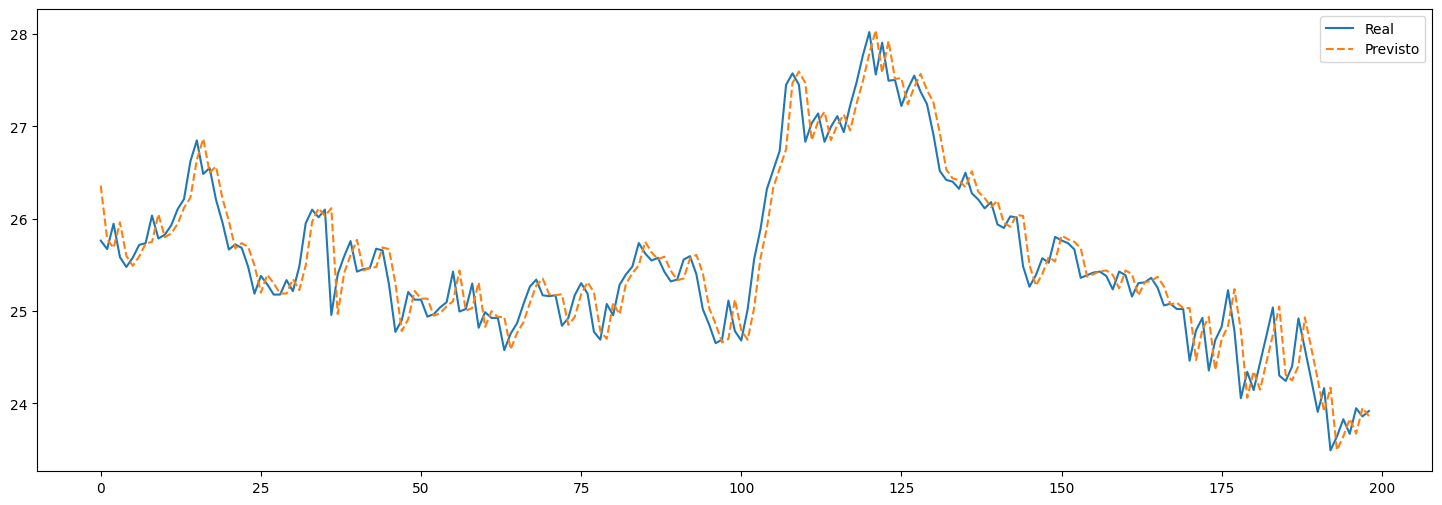

In [108]:
# 1. Prever no conjunto de teste
y_pred = model.predict(X_test)

# 2. Desnormalizar (voltar para escala original)
y_test_real = scaler.inverse_transform(y_test)
y_pred_real = scaler.inverse_transform(y_pred)

# 3. Calcular métricas
from sklearn.metrics import root_mean_squared_error, mean_absolute_percentage_error

mape = mean_absolute_percentage_error(y_test_real, y_pred_real)
rmse = root_mean_squared_error(y_test_real, y_pred_real)
r2 = r2_score(y_test_real, y_pred_real)

print(f"MAPE: {mape}")
print(f"RMSE: {rmse}")
print(f"R²: {r2}")

# 4. Plotar resultados

plt.plot(y_test_real, label="Real")
plt.plot(y_pred_real, label="Previsto", linestyle="--")
plt.legend()
plt.show()

In [107]:
"""train_results = pd.DataFrame({
    "Real": y_train_real,
    "Previsto": y_pred_train_real
})
"""
test_results = pd.DataFrame({
    "Real": y_test_real.reshape(-1),
    "Previsto": y_pred_real.reshape(-1)
})

#all_results = pd.concat(train_results, test_results, axis=0)

In [105]:
len(y_pred_real)

1786